In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.optim.lr_scheduler import ExponentialLR
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def evaluate(predictions, labels):
    """
    This function takes predictions and labels as input, which are numpy arrays, and prints the accuracy, 
    F1 score, AUROC score, confusion matrix, and AUROC curve.
    """
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    auroc = roc_auc_score(labels, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    
    # Generate AUROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC Curve")
    plt.show()
    
    # Print metrics
    print("Accuracy: {:.2f}%".format(accuracy*100))
    print("F1 Score: {:.2f}".format(f1))
    print("AUROC Score: {:.2f}".format(auroc))


In [3]:
# Seeding to help make results reproduceable
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Building custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, X_train, y_train, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        label = self.y_train.iloc[index]
        image_path = self.X_train.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        return image, torch.tensor(label)

In [5]:
# Building valid dataset
class ValidDataset(Dataset):
    def __init__(self, root_dir, X_train, y_train, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        label = self.y_train.iloc[index]
        image_path = self.X_train.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        p = np.random.randint(0,100)
        if label == 1:
            noise = np.random.randint(0,25, size = (150,150,3)).astype(float)
            image= np.clip(image//2+noise//2, 0, 255).astype(np.uint8)
            image = Image.fromarray(image)
        image = transforms.ToTensor()(image)
        image = self.transform(image)
        return image, torch.tensor(label)

In [6]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=2, padding=1),  # 150 x 150 x 3 -> 75 x 75 x 16
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(6, 12, kernel_size=3, stride=2, padding=1), # 75 x 75 x 16 -> 38 x 38 x 32
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, stride=2, padding=1), # 38 x 38 x 32 -> 19 x 19 x 64
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=1), # 19 x 19 x 64 -> 10 x 10 x 128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 10 x 10 x 128 -> 5 x 5 x 256
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 5 x 5 x 256 -> 9 x 9 x 128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # 9 x 9 x 128 -> 17 x 17 x 64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # 17 x 17 x 64 -> 33 x 3 x 32
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1), # 33 x 33 x 32 -> 80 x 80 x 16
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1)  # 80 x 80 x 16 -> 160 x 160 x 3
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Define the training function
def train(model, train_loader, num_epochs, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = ExponentialLR(optimizer, 
                          gamma = 0.95)
    temp1 = 0
    temp2 = 0
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        for data in train_loader:
            img, _ = data
            img = img.float()
            img = (img - img.min()) / (img.max() - img.min())
            img = img.to(device)
            optimizer.zero_grad()
            output = model(img)
            temp1 = output[0]
            temp2 = img[0]
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        train_loss /= len(train_loader.dataset)
        
        if(epoch%50 == 0):
            print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss} \t LR: {scheduler.get_last_lr()[0]}')
            
            fig, axs = plt.subplots(1, 2)

            # plot temp1 in the first subplot
            axs[0].imshow(temp1.cpu().detach().numpy().transpose(1, 2, 0))

            # plot temp2 in the second subplot
            axs[1].imshow(temp2.cpu().detach().numpy().transpose(1, 2, 0))

            # display the subplots
            plt.show()
        scheduler.step()

In [8]:
# Define the anomaly detection function
def anomaly_detection(model, test_loader, device, threshold = None):
    criterion = nn.MSELoss()
    labels = []
    preds = []
    test_loss = []
    print(len(test_loader))
    with torch.no_grad():
        for data in tqdm(test_loader):
            img, label = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            labels.append(label.item())
            test_loss.append(loss.item())

    if threshold == None:
        threshold = np.mean(test_loss)
    print("Threshold: ", threshold)

    for i in range(len(test_loss)):
        preds.append(test_loss[i] > threshold)
    
    plt.scatter(range(len(test_loss)), test_loss)
    plt.title('Reconstruction Loss for Test Examples')
    plt.xlabel('Test Example Index')
    plt.ylabel('Reconstruction Loss')
    plt.show()
    evaluate(preds, labels)

Label Encoding Mapping:
no_sub -> 0
sub -> 1
Data lengths:  4500 1000 4500 1000


  0%|          | 0/50 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 	Training Loss: 0.005495915943135818 	 LR: 0.01


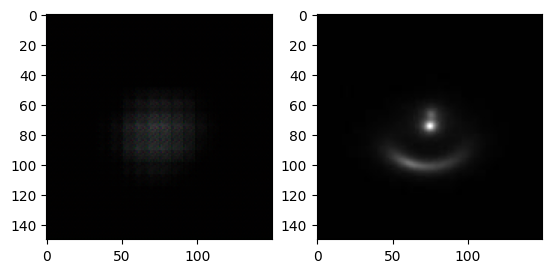

100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


In [9]:
torch.cuda.empty_cache()
base_path = '.'
root_dir = '.'
SEED = 42
BATCH_SIZE = 64
num_workers = 2
train_csv_path = f'{base_path}/anomaly_train.csv'
test_csv_path = f'{base_path}/anomaly_test.csv'
seed_everything(SEED)

#  Loading the train data
train_df = pd.read_csv(train_csv_path) 
test_df = pd.read_csv(test_csv_path)
le = preprocessing.LabelEncoder()
test_df['label'] = le.fit_transform(test_df['label'])
train_df['label'] = le.transform(train_df['label'])

print("Label Encoding Mapping:")
for label, encoded_value in zip(le.classes_, le.transform(le.classes_)):
    print(f"{label} -> {encoded_value}")

# building training and validation sets
y_train = train_df['label']
X_train = train_df['path']
X_valid = test_df['path']
y_valid = test_df['label']
print('Data lengths: ', len(X_train), len(X_valid), len(y_train), len(y_valid))

# Data transforms
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((150,150)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
                                        ])
test_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((150,150)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
                                        ])
# Load the CIFAR-10 dataset
train_dataset = CustomDataset(root_dir,X_train, y_train,train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_dataset = ValidDataset(root_dir,X_valid, y_valid,test_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=num_workers)

# Set up GPU device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Train the autoencoder model
model = Autoencoder().to(device)
train(model, train_loader, num_epochs=50, device = device)

1000


100%|██████████| 1000/1000 [00:03<00:00, 295.31it/s]


Threshold:  0.0008005265303872874


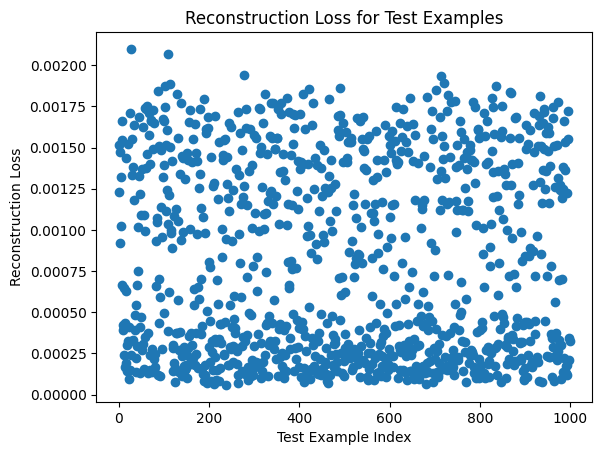

Confusion Matrix:
 [[481  19]
 [ 60 440]]


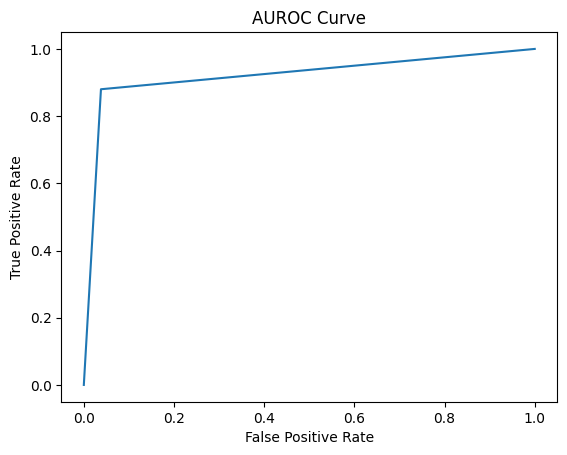

Accuracy: 92.10%
F1 Score: 0.92
AUROC Score: 0.92


In [10]:

# Detect anomalies in the test dataset
threshold = 0.5
anomaly_detection(model = model, test_loader = valid_loader, device = device)
